# Telco Customer Churn Prediction and Analysis

## Table of Contents
1. Introduction
2. Data Loading & Overview
3. Data Cleaning & Preprocessing
4. Exploratory Data Analysis (EDA)
5. Statistical Tests for Feature Relevance
6. Feature Engineering
7. Feature Selection

## 1. Introduction

This notebook implements an end-to-end pipeline for Telco customer churn prediction:
- data loading and cleaning
- exploratory data analysis
- statistical testing
- feature engineering (original team implementation — kept unchanged)
- feature selection (original team implementation — kept unchanged)
- model training and evaluation for LightGBM and CatBoost
- final comparison and conclusion

The goal is to identify customers at risk of churn and compare models.

## 2. Data Loading & Overview

In [1]:
import pandas as pd

In [4]:
data = pd.read_csv('Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
data.shape

(7043, 21)

In [6]:
data.dtypes.value_counts()

object     18
int64       2
float64     1
Name: count, dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [9]:
data.duplicated().sum()

np.int64(0)

## 3. Data Cleaning & Preprocessing

We will perform the main cleaning steps:
- convert TotalCharges to numeric and handle missing values
- basic inspections (duplicates, missing values)
- keep a cleaned copy saved to `../dataset/cleaned_Telco-Customer-Churn.csv` for reproducibility

In [10]:
import plotly.express as px

In [11]:
cleaned_data = data.copy()

In [12]:
# convert TotalCharges to numeric
cleaned_data['TotalCharges'] = pd.to_numeric(cleaned_data['TotalCharges'], errors='coerce')

In [13]:
cleaned_data.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [14]:
cleaned_data.duplicated().sum()

np.int64(0)

In [15]:
# drop rows where TotalCharges is missing
cleaned_data = cleaned_data.dropna()

In [16]:
cleaned_data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## 4. Exploratory Data Analysis (EDA)

We will make the basic descriptive statistics for numeric columns ,inspect categorical distributions and plot numeric boxplots and histograms.
The visualizations help detect patterns and potential issues to consider in modeling.

In [17]:
# 1- numeric columns
numeric_cols = ['tenure','MonthlyCharges','TotalCharges']
cleaned_data[numeric_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


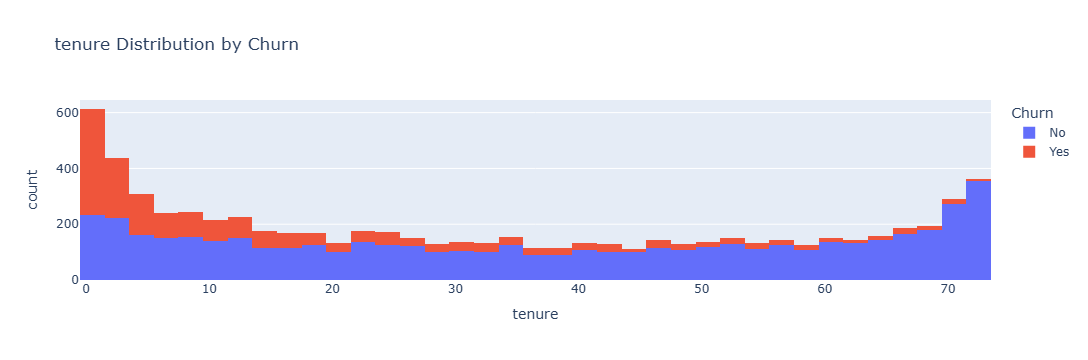

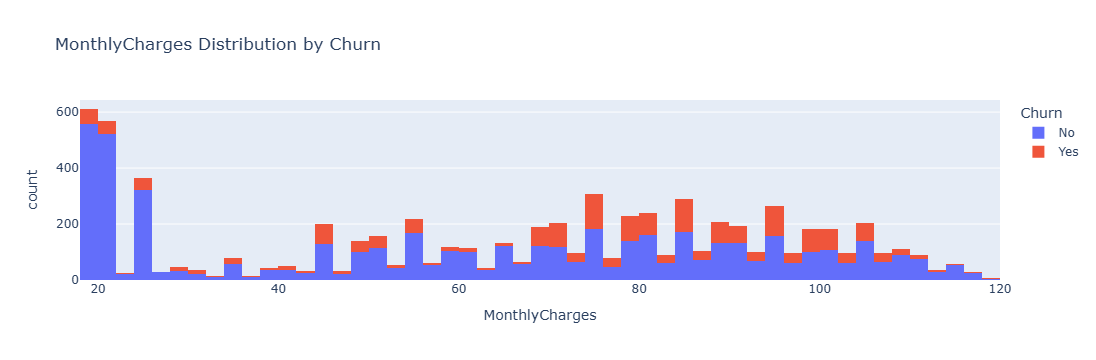

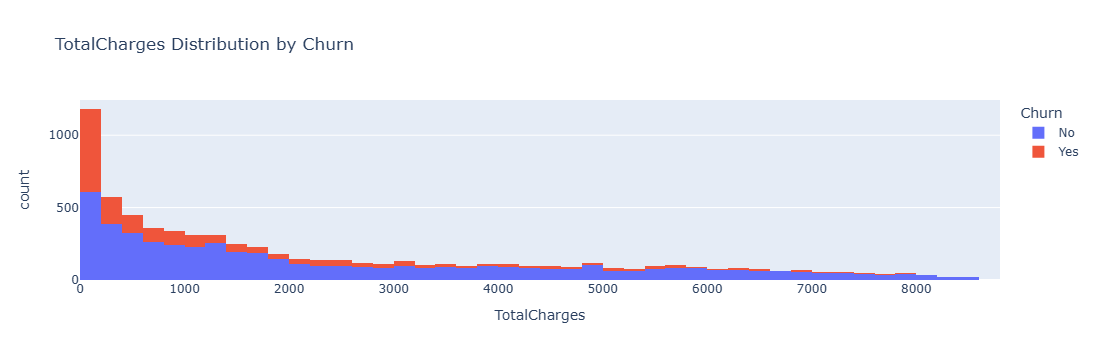

In [18]:
# distribution by churn for numeric columns
for col in numeric_cols:
    fig = px.histogram(cleaned_data,x= col,color='Churn',title=f'{col} Distribution by Churn')
    fig.show()

In [ ]:
# outliers
for col in numeric_cols:
    fig = px.box(cleaned_data,y=col,points='all',title=f'{col} Boxplot')
    fig.show()

In [19]:
# categorical columns
cat_cols = cleaned_data.select_dtypes(include='object').columns.to_list()
cat_cols

['customerID',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [20]:
# value distribution
for col in cat_cols:
    print(cleaned_data[col].value_counts(normalize=True).head())

customerID
7590-VHVEG    0.000142
5575-GNVDE    0.000142
3668-QPYBK    0.000142
7795-CFOCW    0.000142
9237-HQITU    0.000142
Name: proportion, dtype: float64
gender
Male      0.504693
Female    0.495307
Name: proportion, dtype: float64
Partner
No     0.517491
Yes    0.482509
Name: proportion, dtype: float64
Dependents
No     0.701507
Yes    0.298493
Name: proportion, dtype: float64
PhoneService
Yes    0.903299
No     0.096701
Name: proportion, dtype: float64
MultipleLines
No                  0.481371
Yes                 0.421928
No phone service    0.096701
Name: proportion, dtype: float64
InternetService
Fiber optic    0.440273
DSL            0.343572
No             0.216155
Name: proportion, dtype: float64
OnlineSecurity
No                     0.497298
Yes                    0.286547
No internet service    0.216155
Name: proportion, dtype: float64
OnlineBackup
No                     0.438993
Yes                    0.344852
No internet service    0.216155
Name: proportion, dtype: flo

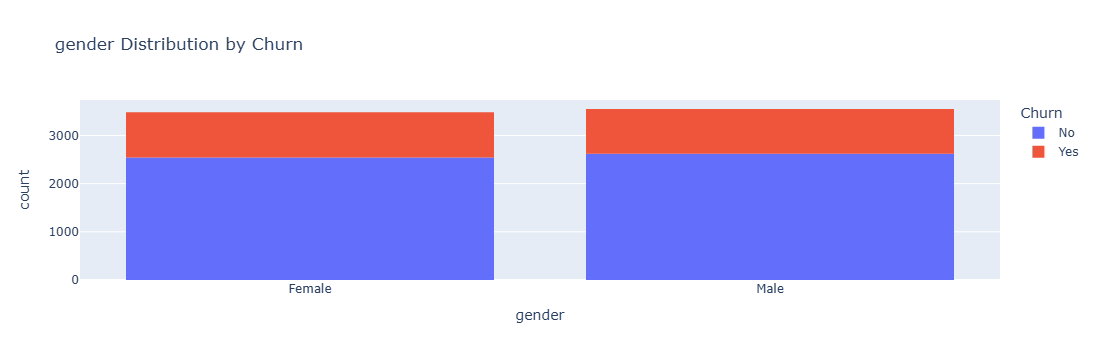

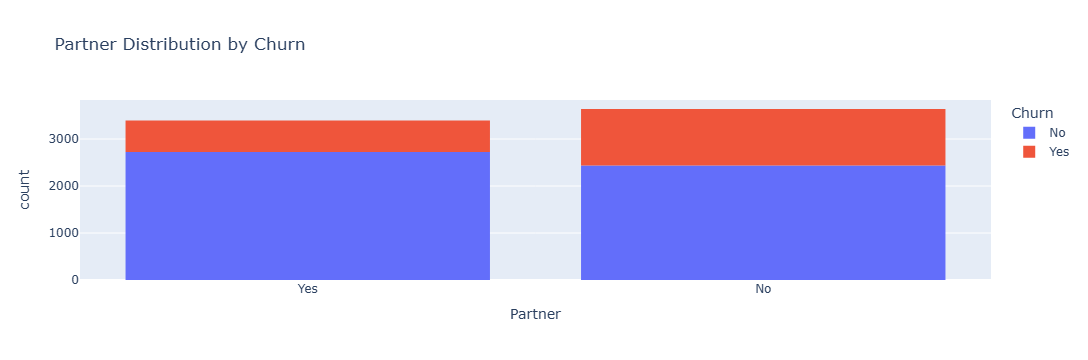

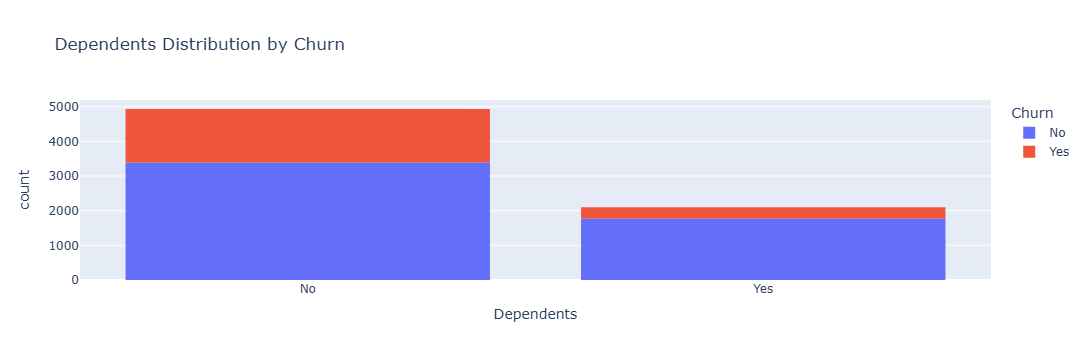

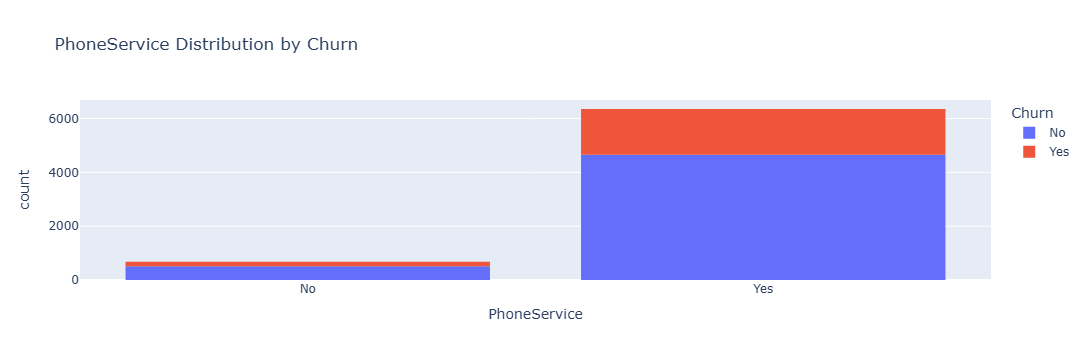

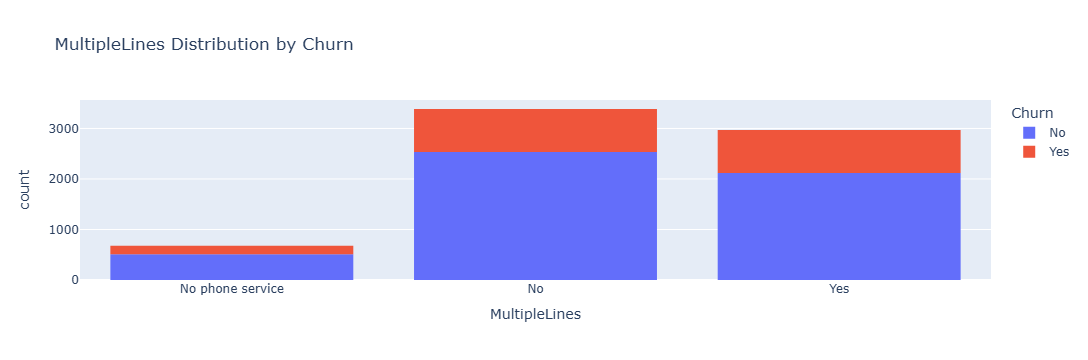

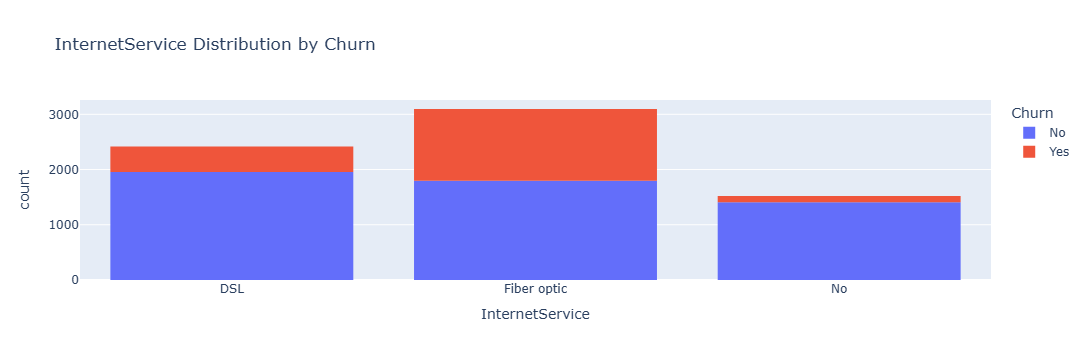

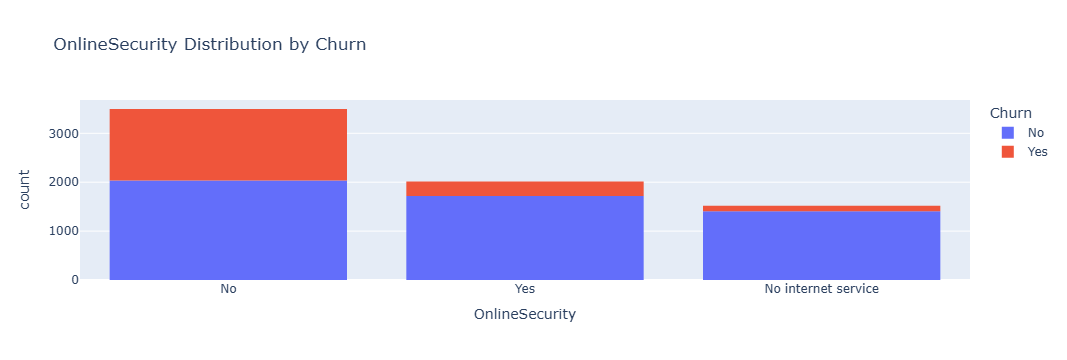

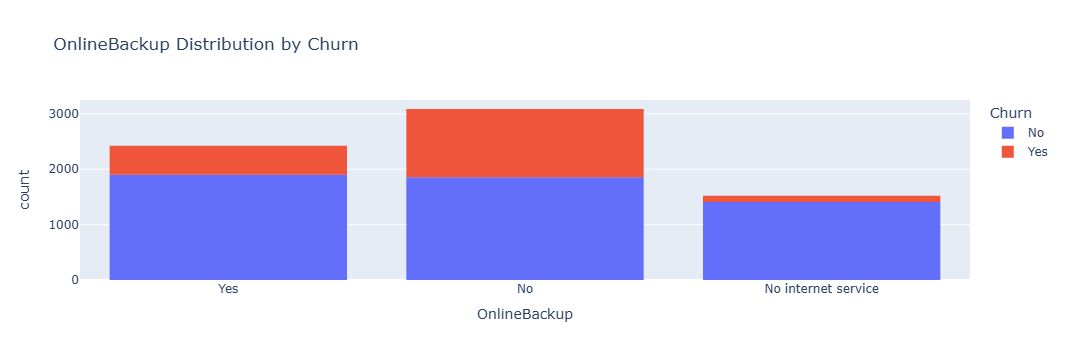

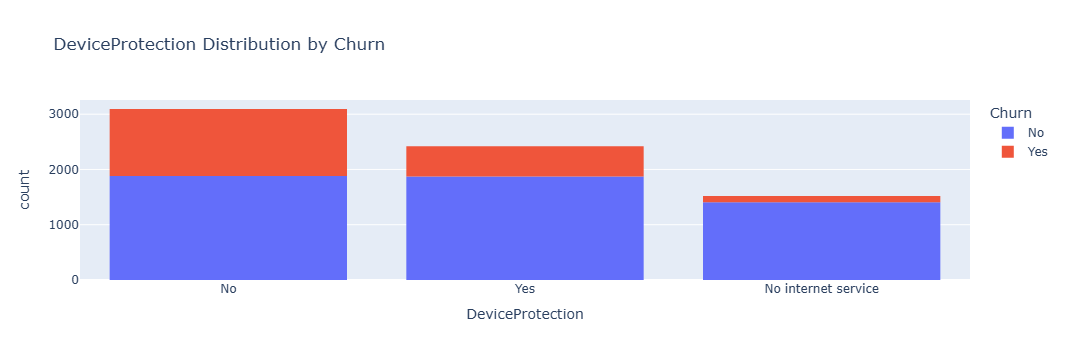

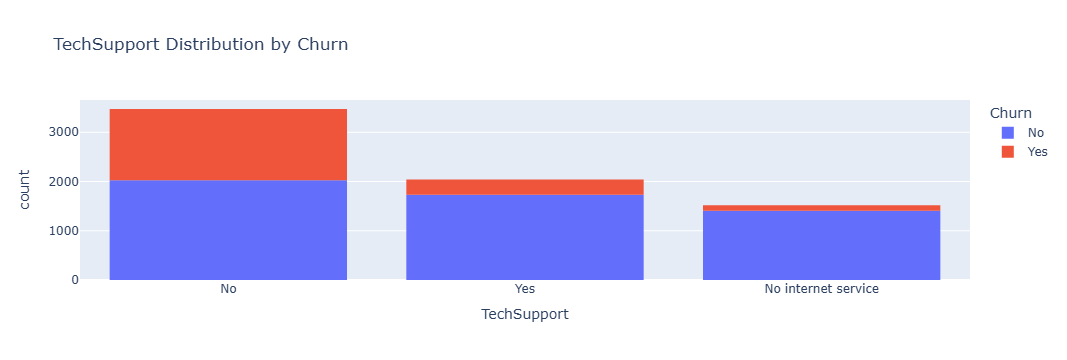

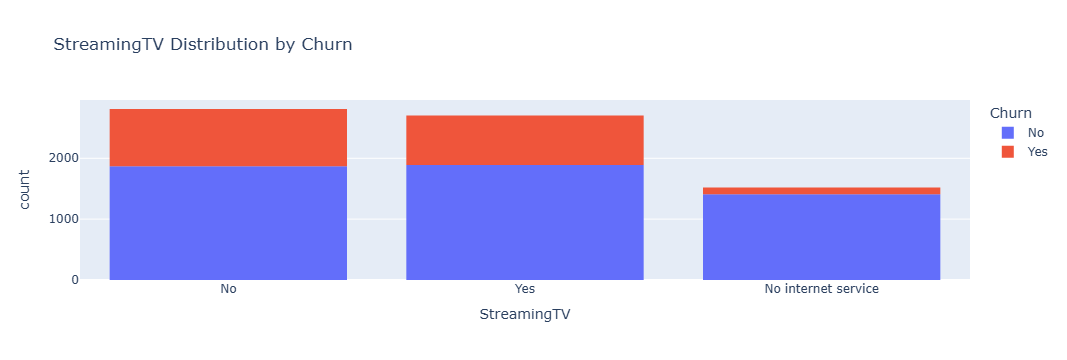

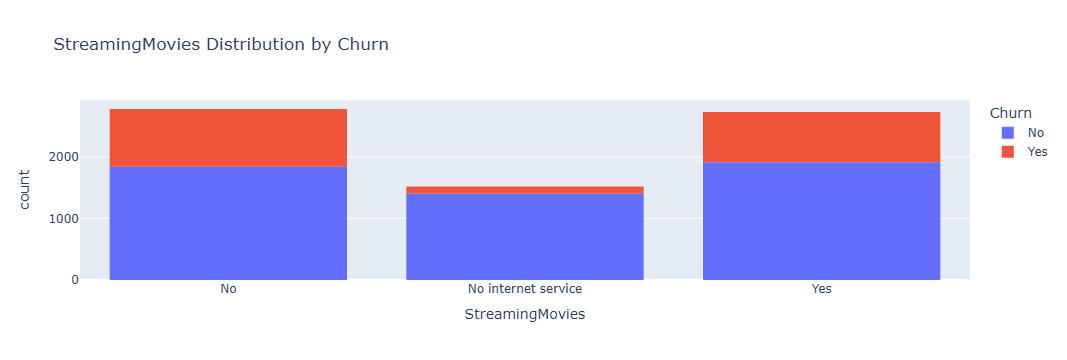

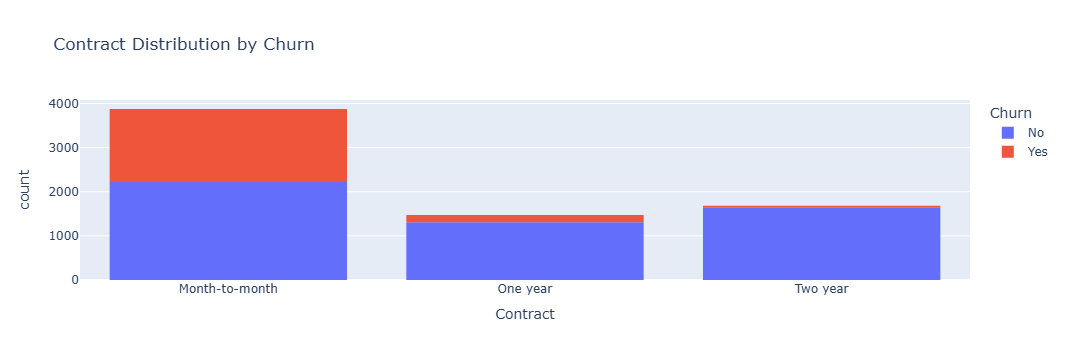

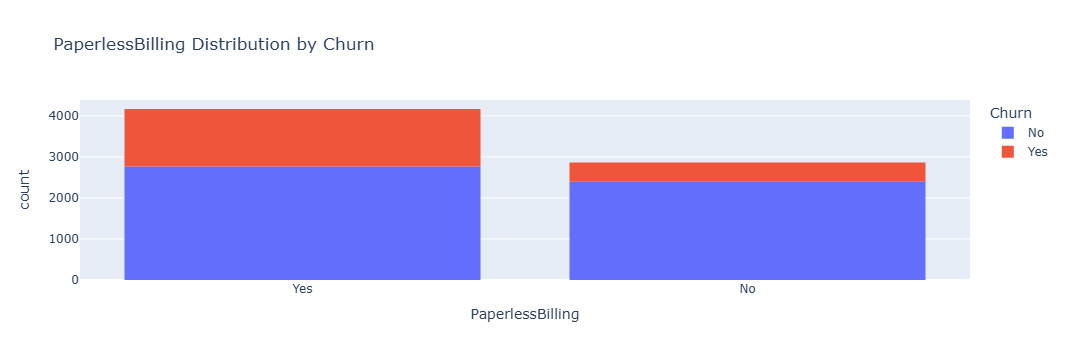

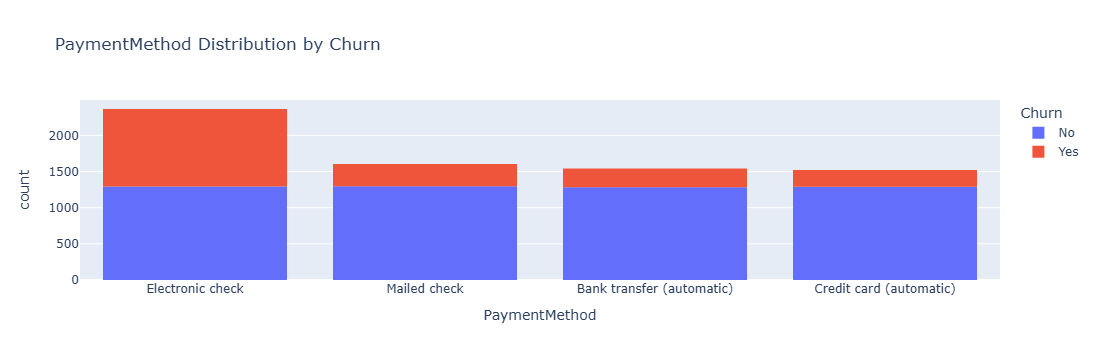

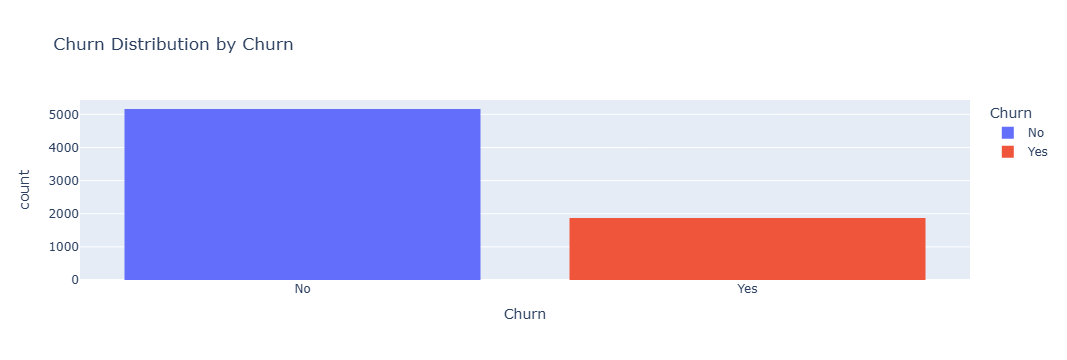

In [21]:
# distribution by churn for categorical columns
for col in cat_cols:
    if col != 'customerID':
        fig= px.histogram(cleaned_data,x=col,color='Churn',title=f'{col} Distribution by Churn')
        fig.show()

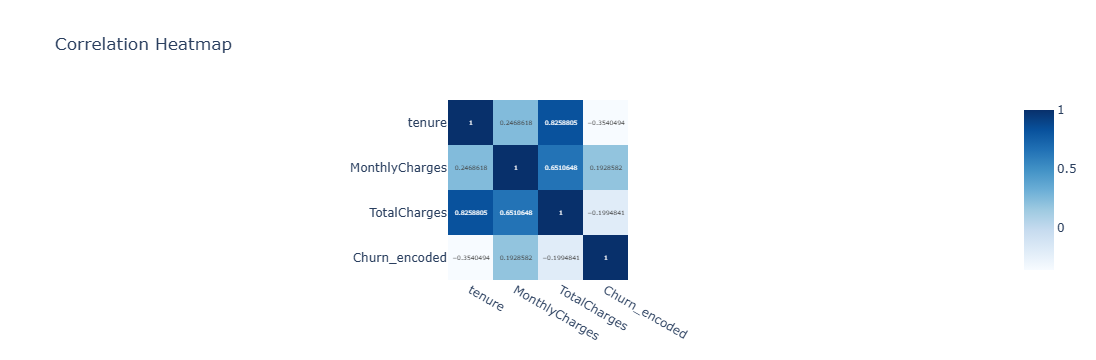

In [22]:
# Correlation Matrix
cleaned_data['Churn_encoded'] = cleaned_data['Churn'].map({'No': 0, 'Yes': 1})

corr = cleaned_data[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_encoded']].corr()

fig = px.imshow(corr, text_auto=True, color_continuous_scale='Blues', title='Correlation Heatmap')
fig.show()

## Key EDA Insights

- Tenure is strongly associated with churn: customers with **shorter tenure** are much more likely to churn than long-tenure customers. This suggests tenure is a primary retention indicator.
- MonthlyCharges shows a positive relationship with churn: **higher monthly charges** tend to appear more frequently among churners.
- Contract type is highly informative: **month-to-month contracts** show much higher churn rates than 1-year or 2-year contracts.
- Paperless billing and certain payment methods (e.g., non-automatic payment) have higher churn proportions compared to customers with contract commitments or automatic payments.
- Some service indicators (e.g., lack of OnlineSecurity or TechSupport, presence of Fiber Internet) are more common in churned customers. These are candidate behavioral/service risk factors.
- There are no extreme, data-breaking outliers in the numeric features that justify automatic removal — many high values represent real customer behavior (e.g., short-tenure with high charges).

In [23]:
cleaned_data.to_csv('cleaned_Telco-Customer-Churn.csv', index=False)

## 5.Statistical Tests for Feature Relevance:
We now perform statistical tests to understand which features are signifciantly associated with customer churn.

We’ll use:
Chi-Square Test for categorical features  
Mann–Whitney U Test (non-parametric) for numerical features  


In [ ]:
#pip install scipy

In [25]:
from scipy.stats import chi2_contingency, mannwhitneyu
import pandas as pd
cleaned_data = pd.read_csv('cleaned_Telco-Customer-Churn.csv')
# --- Chi-Square Test  ---
cat_cols = cleaned_data.select_dtypes(include='object').columns.drop('customerID')

chi2_results = []
for col in cat_cols:
    contingency = pd.crosstab(cleaned_data[col], cleaned_data['Churn'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    chi2_results.append({'Feature': col, 'Chi2': chi2, 'p-value': p})

chi2_df = pd.DataFrame(chi2_results).sort_values('p-value')
display(chi2_df)

print('Categorical features with p < 0.05 are significantly related to churn.')


,Feature,Chi2,p-value
15,Churn,7026.876495,0.000000e+00
12,Contract,1179.545829,7.326182e-257
6,OnlineSecurity,846.677389,1.400687e-184
9,TechSupport,824.925564,7.407808e-180
5,InternetService,728.695614,5.831199e-159
14,PaymentMethod,645.429900,1.426310e-139
7,OnlineBackup,599.175185,7.776099e-131
8,DeviceProtection,555.880327,1.959389e-121
11,StreamingMovies,374.268432,5.353560e-82
10,StreamingTV,372.456502,1.324641e-81


Categorical features with p < 0.05 are significantly related to churn.


In [26]:
# --- Mann–Whitney U Test for Numerical Variables ---
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in num_cols:
    churn_yes = cleaned_data[cleaned_data['Churn'] == 'Yes'][col]
    churn_no = cleaned_data[cleaned_data['Churn'] == 'No'][col]
    stat, p = mannwhitneyu(churn_yes, churn_no)
    print(f'{col}: p-value = {p:.4f}')

print('numeric features with p < 0.05 differ significantly between churn groups.')


tenure: p-value = 0.0000
MonthlyCharges: p-value = 0.0000
TotalCharges: p-value = 0.0000
numeric features with p < 0.05 differ significantly between churn groups.


### Insights:
Categorical features such as Contract, PaymentMethod, and InternetService often show strong significance.  
Numerical features tenure and MonthlyCharges typically have significant differences between churned and retained customers.


## 6.Feature Engineering:
Now we create new features that capture customer behavior and service usage patterns to improve model performance.

In [27]:
data = pd.read_csv('cleaned_Telco-Customer-Churn.csv')
cleaned_data = data.copy()

In [28]:
print(cleaned_data.columns.tolist())

['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Churn_encoded']


In [29]:
# 1.Binary encoding
replace_map = {
    'No internet service': 'No',
    'No phone service': 'No'
}

cols_with_no_service = [
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]

for col in cols_with_no_service:
    cleaned_data[col] = cleaned_data[col].replace(replace_map)

binary_cols = [col for col in cleaned_data.columns if set(cleaned_data[col].dropna().unique()) <= {'Yes', 'No'}]

for col in binary_cols:
    cleaned_data[col] = cleaned_data[col].map({'Yes': 1, 'No': 0})

print('Binary encoding completed successfully!')


Binary encoding completed successfully!


In [30]:
# 2.Tenure Groups
cleaned_data['tenure_group'] = pd.cut(
    cleaned_data['tenure'],
    bins=[0, 12, 24, 48, 72],
    labels=['0:12m', '13:24m', '25:48m', '49:72m']
)

# 3.Average Monthly Spending per Tenure ---
cleaned_data['AvgChargesPerMonth'] = cleaned_data['TotalCharges'] / cleaned_data['tenure'].replace(0, 1)

# 4.Service Count
service_cols = ['PhoneService', 'MultipleLines' ,'OnlineSecurity', 
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                'StreamingTV', 'StreamingMovies']
cleaned_data['ServiceCount'] = cleaned_data[service_cols].apply(lambda x: (x == 'Yes').sum(), axis=1)

# 5.One-Hot Encode Multi-Category Columns
multi_cat_cols = ['Contract', 'PaymentMethod', 'InternetService']
cleaned_data = pd.get_dummies(cleaned_data, columns=multi_cat_cols, drop_first=True)

# 6.Interaction Feature: Tenure × MonthlyCharges
cleaned_data['Tenure_x_Charges'] = cleaned_data['tenure'] * cleaned_data['MonthlyCharges']
print('Feature engineering completed.')
cleaned_data.to_csv('feature_engineered_telco.csv', index=False)
print('Saved as feature_engineered_telco.csv')

Feature engineering completed.
Saved as feature_engineered_telco.csv


### Insights:
Tenure groups help the model capture retention patterns by time range.  
AvgChargesPerMonth measures spending consistency.  
ServiceCount captures customer engagement with multiple services.  
Binary encoding prepares categorical columns for modeling.  
Tenure Charges interaction identifies high-paying short-tenure customers (often churn-prone).  


## 7. Feature Selection

In [31]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df = pd.read_csv('feature_engineered_telco.csv')

# Display shape and first few rows
print(df.shape)
df.head()

(7032, 30)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,AvgChargesPerMonth,ServiceCount,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,Tenure_x_Charges
0,7590-VHVEG,Female,0,1,0,1,0,0,0,1,...,29.850000,0,False,False,False,True,False,False,False,29.85
1,5575-GNVDE,Male,0,0,0,34,1,0,1,0,...,55.573529,0,True,False,False,False,True,False,False,1936.30
2,3668-QPYBK,Male,0,0,0,2,1,0,1,1,...,54.075000,0,False,False,False,False,True,False,False,107.70
3,7795-CFOCW,Male,0,0,0,45,0,0,1,0,...,40.905556,0,True,False,False,False,False,False,False,1903.50
4,9237-HQITU,Female,0,0,0,2,1,0,0,0,...,75.825000,0,False,False,False,True,False,True,False,141.40


In [32]:
# Define X (features) and y (target)
X = df.drop(['customerID', 'Churn_encoded', 'Churn'], axis=1, errors='ignore')
y = df['Churn_encoded']

In [ ]:
#Convert All Columns to Numeric
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X.dtypes
#X.head()

gender                                   float64
SeniorCitizen                              int64
Partner                                    int64
Dependents                                 int64
tenure                                     int64
PhoneService                               int64
MultipleLines                              int64
OnlineSecurity                             int64
OnlineBackup                               int64
DeviceProtection                           int64
TechSupport                                int64
StreamingTV                                int64
StreamingMovies                            int64
PaperlessBilling                           int64
MonthlyCharges                           float64
TotalCharges                             float64
tenure_group                             float64
AvgChargesPerMonth                       float64
ServiceCount                               int64
Contract_One year                           bool
Contract_Two year   

In [ ]:
#Normalize the Features (Scaling)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
#Apply the Chi-Square Test
selector = SelectKBest(score_func=chi2, k=10)
selector.fit(X_scaled, y)

selected_features = X.columns[selector.get_support()]
print('Top 10 Features Selected using Chi-Square Test:')
print(selected_features)


Top 10 Features Selected using Chi-Square Test:
Index(['SeniorCitizen', 'Dependents', 'tenure', 'OnlineSecurity',
       'TechSupport', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Electronic check', 'InternetService_Fiber optic',
       'InternetService_No'],
      dtype='object')


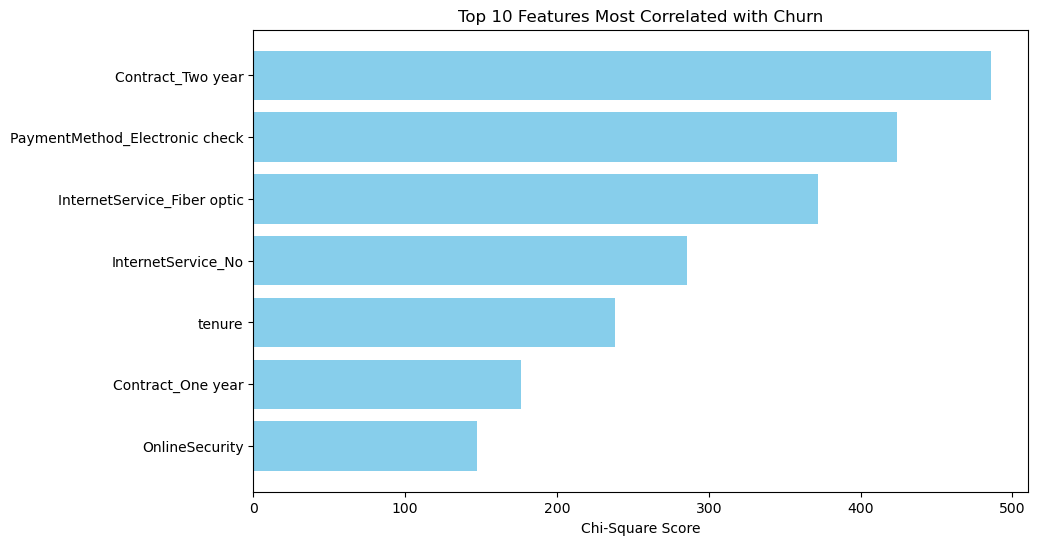

In [ ]:
#Visualize Top 10 Features
import matplotlib.pyplot as plt
import numpy as np

# Get chi2 scores and feature names
chi2_scores = selector.scores_
feature_names = X.columns

# Sort features by importance (descending)
sorted_indices = np.argsort(chi2_scores)[::-1][:10]
top_features = feature_names[sorted_indices]
top_scores = chi2_scores[sorted_indices]

# Plot
plt.figure(figsize=(10,6))
plt.barh(top_features, top_scores, color='skyblue')
plt.xlabel('Chi-Square Score')
plt.title('Top 10 Features Most Correlated with Churn')
plt.gca().invert_yaxis()
plt.show()


### Insights:

Contract Type & Payment Method
Customers on yearly contracts or automatic payments are less likely to churn.

InternetService & Support
Fiber optic users or those without OnlineSecurity/TechSupport show higher churn rates.

Tenure (Customer Age)
Longer-tenure customers are more loyal.

Combined Feature (Tenure_x_Charges)
Shows how spending consistency over time affects churn.

SeniorCitizen
Older customers might have specific service preferences or needs impacting retention.

In [14]:
!pip install matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 849.2 kB/s eta 0:00:09
   -- ------------------------------------- 0.5/8.1 MB 849.2 kB/s eta 0:00:09
   -- ------------------------------------- 0.5/8.1 MB 849.2 kB/s eta 0:00:09
   --- ------------------------------------ 0.8/8.1 MB 584.3 kB/s eta 0:00:13
   --- ------------------------------------ 0.8/8.1 MB 584.3 kB/s eta 0:00:13
   --- ------------------------------------ 0.8/8.1 MB 584.3 kB/s eta 0:00:13
   --- ------------------------------------ 0.8/8.1 MB 584.3 kB/s eta 0:00:13
   ------- -------------------------------- 1.6/8.1 MB 758.3 kB/s eta 0:00:09
   --------- ------------------------------ 1.8/8.1 MB 841.9 kB/s eta 0:00:08
   --------- ------------------------------ 1.8/8.1 MB 841.9 kB/s eta 0:00:08
   ----------- ---------------------------- 2.4/8.1 MB 869.2 kB/s eta 0:00:07
   -

In [22]:
#Logistic Regression Model.

SyntaxError: invalid syntax (3047754159.py, line 1)

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# 1.load  dataset
df = pd.read_csv('feature_engineered_telco.csv')

# 2. convert boolean columns to int
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

#3.select FEatures
selected_features = [
    'SeniorCitizen', 'Dependents', 'tenure', 'OnlineSecurity',
    'TechSupport', 'Contract_One year', 'Contract_Two year',
    'PaymentMethod_Electronic check', 'InternetService_Fiber optic',
    'InternetService_No'
]

X = df[selected_features]
y = df['Churn'] 

# 4.split data:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 5-=scale the features 
scaler = StandardScaler()

# fit the scaler only on training data & transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. create + train the Logistic Regression model
lr = LogisticRegression(solver='liblinear', random_state=42)
lr.fit(X_train_scaled, y_train) # train on scaled data'

# 7. preedict on scaled test set
y_pred = lr.predict(X_test_scaled)

# 8. evaluate  model
print("--- Logistic Regression Model Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# show model coefficients to see feature importance
# coefficients indicate the direction and magnitude of the relationship with churn
print("\nModel Coefficients (Scaled):\n")
for feature, coef in zip(selected_features, lr.coef_[0]):
    print(f"{feature:<30} {coef:>10.4f}")


--- Logistic Regression Model Evaluation ---
Accuracy: 0.7889125799573561

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.63      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407


Model Coefficients (Scaled):

SeniorCitizen                      0.1147
Dependents                        -0.1063
tenure                            -0.6826
OnlineSecurity                    -0.2077
TechSupport                       -0.1532
Contract_One year                 -0.3011
Contract_Two year                 -0.5478
PaymentMethod_Electronic check     0.1948
InternetService_Fiber optic        0.4887
InternetService_No                -0.4600


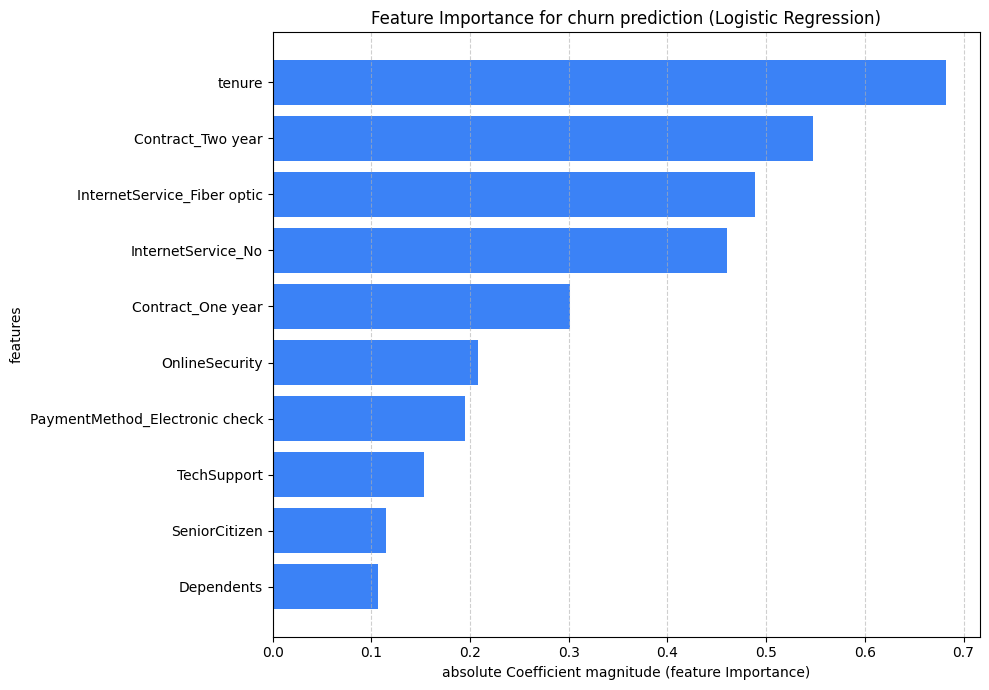


--- feature importance Ranking using Absolute Coefficient ---
                       Feature  Importance
                        tenure    0.682577
             Contract_Two year    0.547775
   InternetService_Fiber optic    0.488739
            InternetService_No    0.460049
             Contract_One year    0.301098
                OnlineSecurity    0.207705
PaymentMethod_Electronic check    0.194785
                   TechSupport    0.153227
                 SeniorCitizen    0.114669
                    Dependents    0.106330


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# feature Importance Visualization (Logistic Regression) ---

# 1.extract coefficients (importance) from the trained model ,Logistic Regression coefficients represent the importance
#use the absolute value to measure magnitude, regardless of the direction (positive/negative).

coefficients = lr.coef_[0]
abs_coefficients = np.abs(coefficients)
features = np.array(selected_features)

# 2.sort features by importance (absolute coefficient value)
#crreate a daataframe for easy sorting and handling
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': abs_coefficients
}).sort_values(by='Importance', ascending=True)

# 3-plot chart
plt.figure(figsize=(10, 7))

#plot horizontal bars
plt.barh(importance_df['Feature'], importance_df['Importance'], color='#3B82F6')

plt.xlabel("absolute Coefficient magnitude (feature Importance)")
plt.ylabel("features")
plt.title("Feature Importance for churn prediction (Logistic Regression)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

#print feature importance as text for reference
print("\n--- feature importance Ranking using Absolute Coefficient ---")
print(importance_df.sort_values(by='Importance', ascending=False).to_string(index=False))


area under curve (AUC): 0.8253


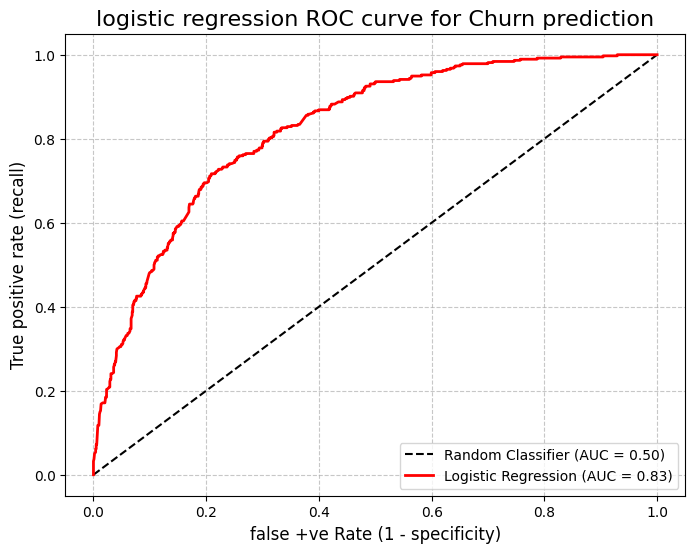

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- 3. ROC CURVE GENERATION AND PLOTTING ---
# 1.get the predicted probabilities for the positive class (class 1: Churn)
y_pred_prob = lr.predict_proba(X_test_scaled)[:, 1]

# 2-calculate the false +ve rate (fpr) and true +ve rate (tpr) for all thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# calculate the area under curve (AUC) for reporting
roc_auc = auc(fpr, tpr)
print(f"area under curve (AUC): {roc_auc:.4f}")

# 3.plot ROC curve
plt.figure(figsize=(8, 6))

# plot baseline (random) classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')

# plt Logistic Regression ROC curve
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})', color="red", linewidth=2)

plt.xlabel('false +ve Rate (1 - specificity)', fontsize=12)
plt.ylabel('True positive rate (recall)', fontsize=12)
plt.title('logistic regression ROC curve for Churn prediction', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [17]:
# In this code, we train a logistic regression that handles imbalanced data by using the class_weight='balanced' parameter.

# - This setting automatically adjusts weights inversely proportional to class frequencies, helping the model to pay more attention to the minority class (e.g., churners).

# - We then train the model on the training data and evaluate its performance on the test data.

# - The evaluation includes accuracy and a detailed classification report to understand how well the model performs on each class.

# - Using class balancing usually improves the model’s ability to correctly identify the minority class, which is often more important in churn prediction

In [20]:
# --- BALANCED LOGISTIC REGRESSION ---

#create the model with class balancing
lr_balanced = LogisticRegression(
    solver='liblinear', 
    random_state=42, 
    class_weight='balanced'  # <--- This is the equivalent parameter
)

# train model
lr_balanced.fit(X_train_scaled, y_train)

# predict
y_pred_balanced = lr_balanced.predict(X_test_scaled)

# evaluate
print(" Accuracy:", accuracy_score(y_test, y_pred_balanced))
print("\n Classification Report (Balanced):\n", classification_report(y_test, y_pred_balanced))


 Accuracy: 0.7235252309879175

 Classification Report (Balanced):
               precision    recall  f1-score   support

           0       0.90      0.71      0.79      1033
           1       0.49      0.77      0.60       374

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.72      0.74      1407



In [1]:
!pip install scikit-learn

   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.7 MB 3.9 MB/s eta 0:00:03
   --- ------------------------------------ 0.8/8.7 MB 3.9 MB/s eta 0:00:03
   ---------- ----------------------------- 2.4/8.7 MB 3.7 MB/s eta 0:00:02
   ------------- -------------------------- 2.9/8.7 MB 3.5 MB/s eta 0:00:02
   ---------------- ----------------------- 3.7/8.7 MB 3.6 MB/s eta 0:00:02
   --------------------- ------------------ 4.7/8.7 MB 3.7 MB/s eta 0:00:02
   -------------------------- ------------- 5.8/8.7 MB 3.9 MB/s eta 0:00:01
   ------------------------------- -------- 6.8/8.7 MB 4.0 MB/s eta 0:00:01
   ---------------------------------- ----- 7.6/8.7 MB 4.0 MB/s eta 0:00:01
   ---------------------------------------  8.7/8.7 MB 4.1 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 4.0 MB/s eta 0:00:00

   ------------- --------

In [5]:
#Gradient Boosting

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


df = pd.read_csv("C:/dataset/feature_engineered_telco.csv")

print(df.head())

target = "Churn"        
X = df.drop(columns=[target])
y = df[target]


X = X.drop(columns=["Churn_encoded"], errors="ignore")

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)



numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()


preprocessor = ColumnTransformer(transformers=[
    ("num", SimpleImputer(strategy="median"), numeric_cols),
    ("cat", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ]), cat_cols)
])


gb = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    validation_fraction=0.1,
    n_iter_no_change=20,
    tol=1e-4,
    random_state=42
)


model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("gb", gb)
])


model.fit(X_train, y_train)


y_pred_val = model.predict(X_val)
y_prob_val = model.predict_proba(X_val)[:, 1]

print("Validation results:")
print("Accuracy:", accuracy_score(y_val, y_pred_val))
print("Precision:", precision_score(y_val, y_pred_val))
print("Recall:", recall_score(y_val, y_pred_val))
print("F1:", f1_score(y_val, y_pred_val))
print("ROC AUC:", roc_auc_score(y_val, y_prob_val))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))



y_pred_test = model.predict(X_test)
y_prob_test = model.predict_proba(X_test)[:, 1]

print("\nTest results:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1:", f1_score(y_test, y_pred_test))
print("ROC AUC:", roc_auc_score(y_test, y_prob_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))




feature_names = numeric_cols + cat_cols
importances = model.named_steps["gb"].feature_importances_

fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

print(fi_df.head(10))




   customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  7590-VHVEG  Female              0        1           0       1   
1  5575-GNVDE    Male              0        0           0      34   
2  3668-QPYBK    Male              0        0           0       2   
3  7795-CFOCW    Male              0        0           0      45   
4  9237-HQITU  Female              0        0           0       2   

   PhoneService  MultipleLines  OnlineSecurity  OnlineBackup  ...  \
0             0              0               0             1  ...   
1             1              0               1             0  ...   
2             1              0               1             1  ...   
3             0              0               1             0  ...   
4             1              0               0             0  ...   

   AvgChargesPerMonth  ServiceCount  Contract_One year  Contract_Two year  \
0           29.850000             0              False              False   
1           55.5

In [8]:
!pip install matplotlib

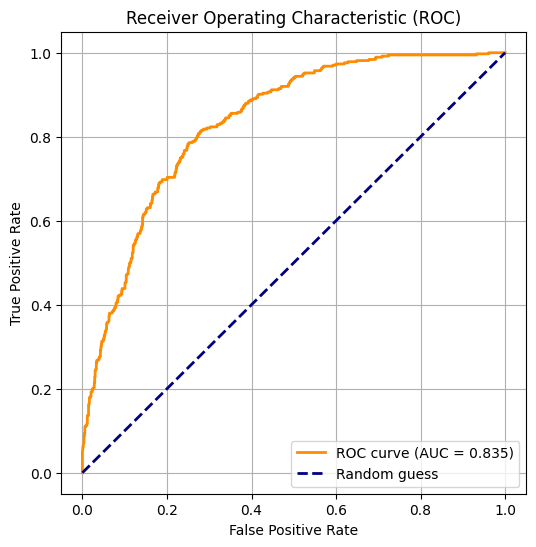

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# --- Compute probabilities and ROC metrics ---
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# --- Plot ROC Curve ---
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

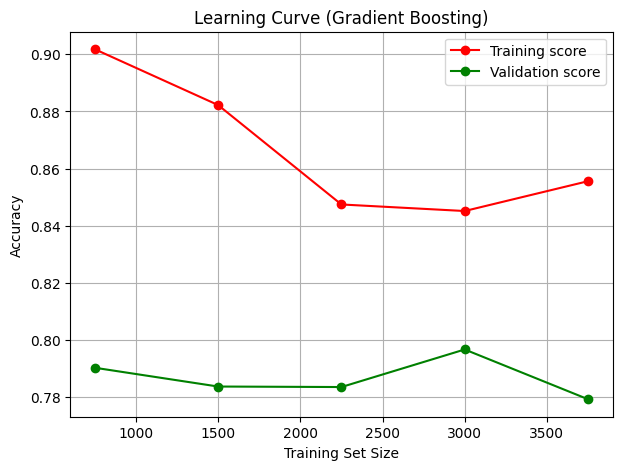

In [11]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# --- Compute learning curve data (lighter version) ---
train_sizes, train_scores, val_scores = learning_curve(
    model, X_trainval, y_trainval,
    cv=3, scoring='accuracy', n_jobs=1,   # 👈 single process
    train_sizes=np.linspace(0.2, 1.0, 5)  # 👈 fewer points
)

# --- Compute mean scores ---
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

# --- Plot learning curve ---
plt.figure(figsize=(7, 5))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Validation score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve (Gradient Boosting)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


   customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  7590-VHVEG  Female              0        1           0       1   
1  5575-GNVDE    Male              0        0           0      34   
2  3668-QPYBK    Male              0        0           0       2   
3  7795-CFOCW    Male              0        0           0      45   
4  9237-HQITU  Female              0        0           0       2   

   PhoneService  MultipleLines  OnlineSecurity  OnlineBackup  ...  \
0             0              0               0             1  ...   
1             1              0               1             0  ...   
2             1              0               1             1  ...   
3             0              0               1             0  ...   
4             1              0               0             0  ...   

   AvgChargesPerMonth  ServiceCount  Contract_One year  Contract_Two year  \
0           29.850000             0              False              False   
1           55.5

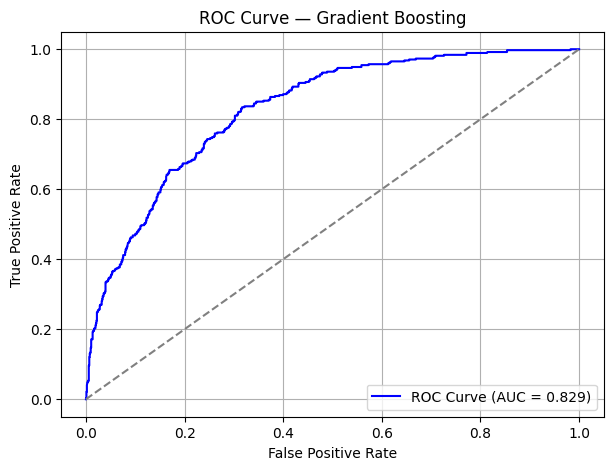

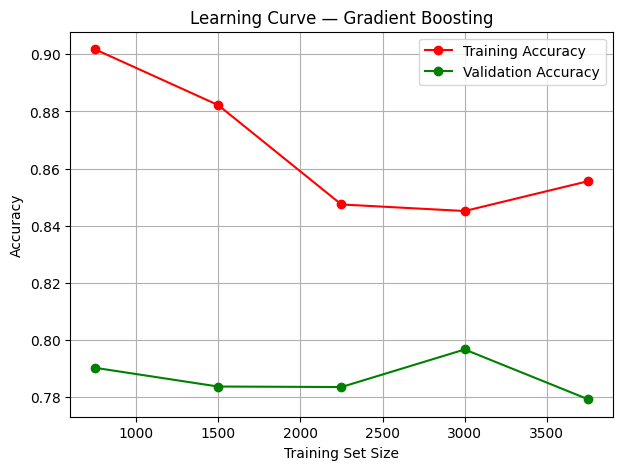

In [12]:
# ==========================
# GRADIENT BOOSTING + ROC + LEARNING CURVE
# ==========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)

# --- Load dataset ---
df = pd.read_csv("C:/dataset/feature_engineered_telco.csv")
print(df.head())

# --- Split features and target ---
target = "Churn"
X = df.drop(columns=[target])
y = df[target]
X = X.drop(columns=["Churn_encoded"], errors="ignore")

# --- Split data ---
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

# --- Preprocessing ---
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ("num", SimpleImputer(strategy="median"), numeric_cols),
    ("cat", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ]), cat_cols)
])

# --- Model ---
gb = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    validation_fraction=0.1,
    n_iter_no_change=20,
    tol=1e-4,
    random_state=42
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("gb", gb)
])

# --- Train model ---
model.fit(X_train, y_train)

# --- Validation Metrics ---
y_pred_val = model.predict(X_val)
y_prob_val = model.predict_proba(X_val)[:, 1]

print("\nValidation results:")
print("Accuracy:", accuracy_score(y_val, y_pred_val))
print("Precision:", precision_score(y_val, y_pred_val))
print("Recall:", recall_score(y_val, y_pred_val))
print("F1:", f1_score(y_val, y_pred_val))
print("ROC AUC:", roc_auc_score(y_val, y_prob_val))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

# --- Test Metrics ---
y_pred_test = model.predict(X_test)
y_prob_test = model.predict_proba(X_test)[:, 1]

print("\nTest results:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1:", f1_score(y_test, y_pred_test))
print("ROC AUC:", roc_auc_score(y_test, y_prob_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

# --- Feature Importance ---
feature_names = numeric_cols + cat_cols
importances = model.named_steps["gb"].feature_importances_

fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

print("\nTop 10 Important Features:")
print(fi_df.head(10))


# ==========================================
# PLOT 1 — ROC Curve
# ==========================================
fpr, tpr, _ = roc_curve(y_val, y_prob_val)
roc_auc = roc_auc_score(y_val, y_prob_val)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve — Gradient Boosting')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# ==========================================
# PLOT 2 — Learning Curve (light version)
# ==========================================
train_sizes, train_scores, val_scores = learning_curve(
    model, X_trainval, y_trainval,
    cv=3, scoring='accuracy', n_jobs=1,
    train_sizes=np.linspace(0.2, 1.0, 5)
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(7, 5))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Validation Accuracy')
plt.title('Learning Curve — Gradient Boosting')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()
